# Notes

This Jupyter Notebook documents an experiment in using federated learning for anomaly detection in health insurance claims. The goal was to build a privacy-preserving model and compare its effectiveness to traditional, centralized models.

---
## Data Preprocessing
The process began with loading a health insurance dataset containing 13 features. To prepare the data for the models, several preprocessing steps were taken:
* **Cleaning**: Missing values in the `age` and `bmi` columns were filled using the mean of each column.
* **Encoding**: Categorical features were converted into a numerical format. Features with high cardinality, like `city` and `job_title`, were handled with Label Encoding.
* **Scaling**: All numerical features were normalized using `StandardScaler` to ensure that no single feature disproportionately influenced the models.

---
## Centralized Model Training
To establish a performance baseline, three different unsupervised anomaly detection models were trained on the full, centralized dataset:
1. **Isolation Forest**: This model identifies anomalies by isolating data points that are "few and different." It performed the best, finding anomalies with a mean claim amount of **$34,275**.
2. **Autoencoder**: A neural network trained to reconstruct normal data, flagging data with high reconstruction error as anomalous. Its anomalies had a mean claim of **$24,726**.
3. **K-Means**: A clustering algorithm that identifies anomalies as data points far from any cluster center. This model had the lowest-performing mean claim amount at **$17,460**.

---
## Federated Learning
Recognizing that an Isolation Forest's tree-based structure is difficult to average in a federated setting, an **Autoencoder** was chosen for the federated model.

* **Environment**: The data was split into 91 client datasets based on the `city` feature to simulate a real-world, non-IID (non-identically distributed) environment.
* **Training**: The model was trained for 20 rounds using the **FedProx** strategy, which helps manage inconsistencies (client drift) between the different client datasets. The model's reconstruction loss steadily decreased, showing stable convergence.

---
## Results and Comparison
The final federated model was evaluated against the centralized benchmarks to measure how well it performed without centralizing sensitive data.

* **Performance**: The federated model identified anomalies with a respectable mean claim amount of **$20,969**.
* **Overlap**: The anomalies found by the federated model had a **50.67%** overlap with the top-performing centralized Isolation Forest and a **48.00%** overlap with the centralized Autoencoder.

The experiment successfully demonstrated that a well-configured federated learning system can produce reliable and comparable results to strong centralized models, offering a viable solution for privacy-preserving analysis in healthcare.

# Start

## Reading project files from zip file
Upload project_archive.zip into /content/ folder of colab


In [1]:
!unzip /content/project_archive.zip

Archive:  /content/project_archive.zip
   creating: fl-tabular/
  inflating: fl-tabular/health.csv   
  inflating: fl-tabular/README.md    
  inflating: fl-tabular/preprocessed_unsupervised.pkl  
   creating: fl-tabular/fltabular/
   creating: fl-tabular/fltabular/__pycache__/
  inflating: fl-tabular/fltabular/__pycache__/task.cpython-312.pyc  
  inflating: fl-tabular/fltabular/__pycache__/__init__.cpython-312.pyc  
  inflating: fl-tabular/fltabular/__pycache__/client_app.cpython-312.pyc  
  inflating: fl-tabular/fltabular/__pycache__/server_app.cpython-312.pyc  
  inflating: fl-tabular/fltabular/server_app.py  
  inflating: fl-tabular/fltabular/client_app.py  
  inflating: fl-tabular/fltabular/task.py  
  inflating: fl-tabular/fltabular/__init__.py  
  inflating: fl-tabular/pyproject.toml  
  inflating: fl-tabular/final_model_fedprox.pkl  


## Installing Dependancies

In [2]:
!cd fl-tabular; pip install -e .

Obtaining file:///content/fl-tabular
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Using cached pathspec-0.12.1-py3-none-any.whl.metadata (21 kB)
INFO: pip is looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-health-checking to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 60.4 MB/s eta 0:00:00
   ━

# Data Visualization and Preprocessing

## Visualization

In [3]:
import pandas as pd

# Load the correct dataset
try:
    df = pd.read_csv("fl-tabular/health.csv")
except FileNotFoundError:
    print("Error: 'health.csv' not found. Please ensure the file is in the correct path.")
    df = None

if df is not None:
    # Group by 'city' and get descriptive statistics for key numerical features
    feature_skew_analysis = df.groupby('city')[['age', 'bmi', 'claim']].describe()

    print("--- Analysis of Feature Distribution Skew Across Clients (Cities) ---")
    # Display statistics for a few cities to show the variation
    print(feature_skew_analysis.head(15))

--- Analysis of Feature Distribution Skew Across Clients (Cities) ---
                age                                                        \
              count       mean        std   min    25%   50%    75%   max   
city                                                                        
Atlanta       262.0  39.820611  14.081396  18.0  27.00  40.5  52.00  64.0   
AtlanticCity  128.0  37.976562  13.645953  18.0  25.00  38.0  48.00  63.0   
Bakersfield   171.0  39.298246  13.139476  18.0  28.00  42.0  50.00  63.0   
Baltimore      68.0  40.794118  14.699537  18.0  26.00  42.0  54.00  64.0   
Bloomington   119.0  40.403361  14.041898  18.0  27.00  41.0  51.50  64.0   
Boston        153.0  39.705882  14.468606  18.0  26.00  40.0  53.00  64.0   
Brimingham    287.0  38.013937  14.276484  18.0  25.00  37.0  50.50  64.0   
Brookings     114.0  37.833333  13.453240  18.0  25.00  36.5  49.00  64.0   
Buffalo       132.0  40.484848  14.651413  18.0  28.00  41.0  53.25  64.0   
Cambri

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv("fl-tabular/health.csv")
X = data.copy()
X_train, _ = train_test_split(X, test_size=0.2, random_state=42)
num_clients = len(X_train['city'].unique())

print(f"Total number of client partitions (unique cities): {num_clients}")

Total number of client partitions (unique cities): 91


--- Dataset 'health.csv' loaded successfully! ---

--- Analysis of Non-IID Data Distribution Across Clients (Cities) ---
           city  num_samples    mean_claim  smoker_rate
0       Atlanta          220  12475.606579     0.171053
1  AtlanticCity          101  13143.371429     0.180952
2   Bakersfield          134  12370.808824     0.161765
3     Baltimore           52  12178.562264     0.169811
4   Bloomington           97  14599.133673     0.244898
5        Boston          125  12464.260000     0.192308
6    Brimingham          225  11991.446610     0.156780
7     Brookings           87  11338.445977     0.126437
8       Buffalo          100  15080.639216     0.225490
9     Cambridge          102  13693.109174     0.174312

--- Generating visualizations of the data skew... ---


/tmp/ipython-input-2114314208.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='city', y='num_samples', data=client_distribution_sorted.head(10), palette='viridis')
/tmp/ipython-input-2114314208.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='city', y='mean_claim', data=client_distribution_sorted.head(10), palette='plasma')
/tmp/ipython-input-2114314208.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[2], x='city', y='smoker_rate', data=client_distribution_sorted.head(10), palette='magma')


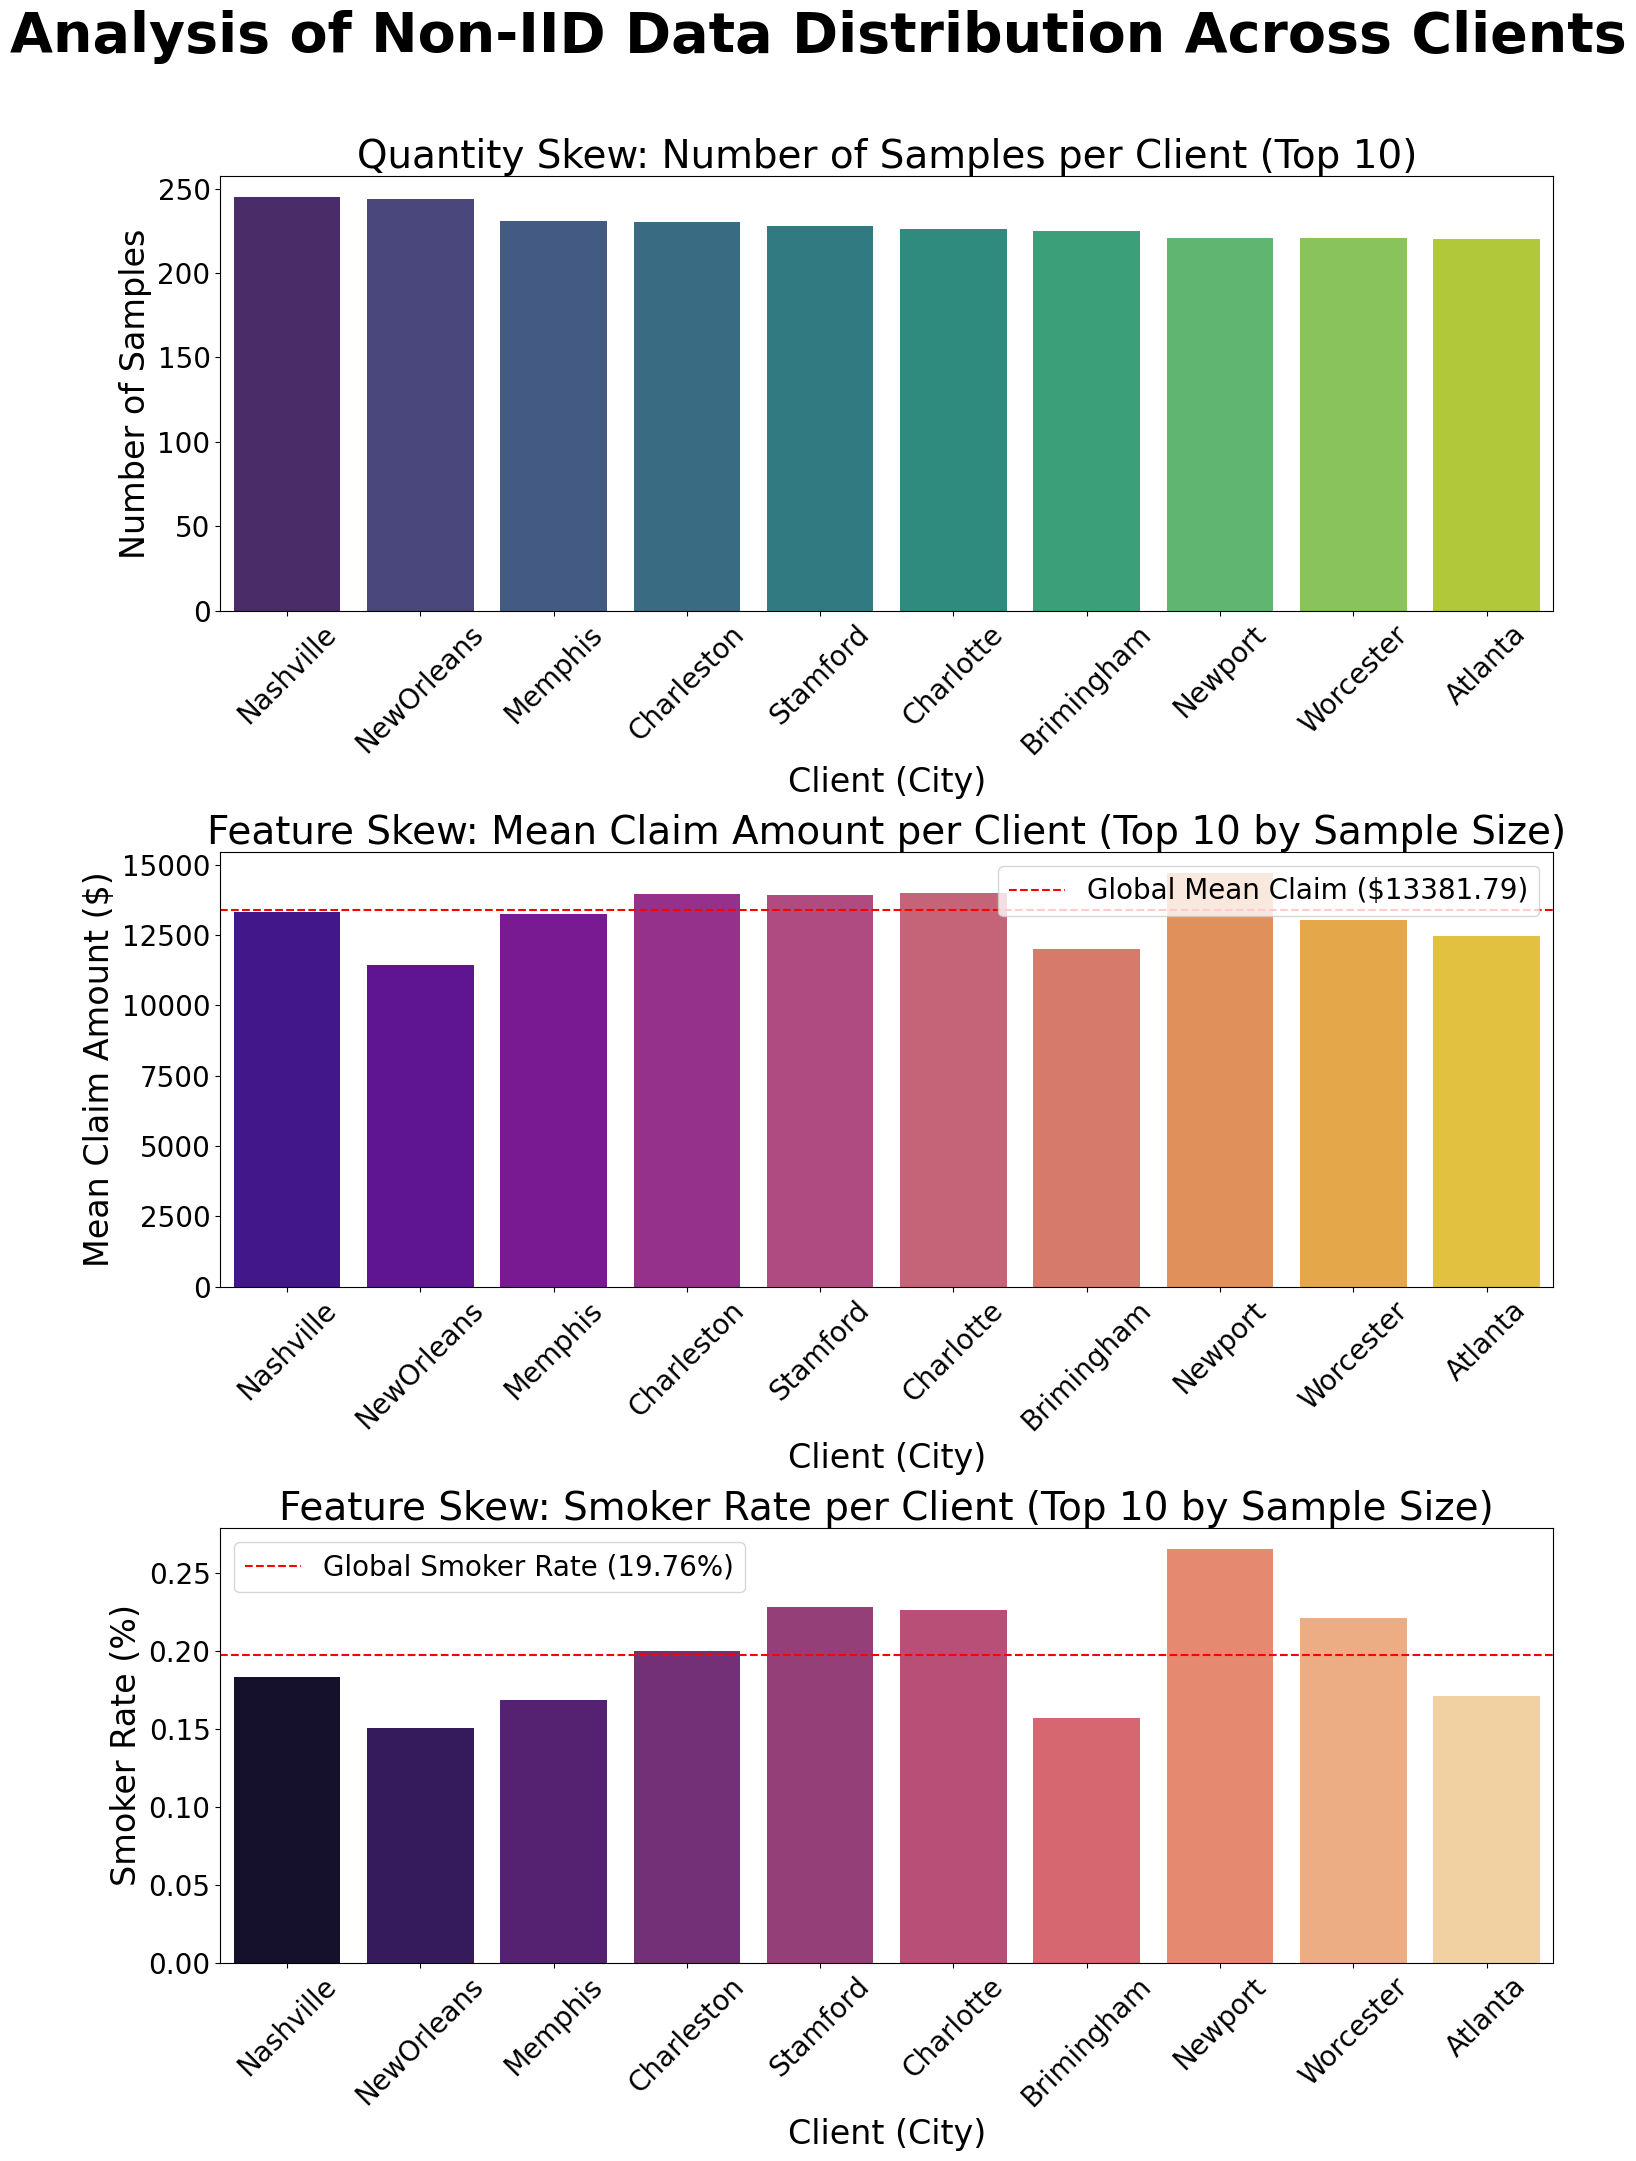

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and perform the train-test split ---
try:
    data = pd.read_csv("fl-tabular/health.csv")
    print("--- Dataset 'health.csv' loaded successfully! ---")
    X = data.copy()
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

    # --- 2. Analyze the distribution of the TRAINING data ---
    client_distribution = X_train.groupby('city').agg(
        num_samples=('age', 'count'),
        mean_claim=('claim', 'mean'),
        smoker_rate=('smoker', 'mean')
    ).reset_index()

    global_means = X_train[['claim', 'smoker']].mean()

    print("\n--- Analysis of Non-IID Data Distribution Across Clients (Cities) ---")
    print(client_distribution.head(10))

    # --- 3. Visualize the Non-IID Data Distribution ---
    print("\n--- Generating visualizations of the data skew... ---")

    # Sort clients by number of samples for better visualization
    client_distribution_sorted = client_distribution.sort_values(by='num_samples', ascending=False)

    # Set up the plot
    fig, axes = plt.subplots(3, 1, figsize=(15, 22)) # Increased figure height for better spacing
    fig.suptitle('Analysis of Non-IID Data Distribution Across Clients', fontsize=40, weight='bold')

    # Plot 1: Quantity Skew (Number of Samples per Client)
    sns.barplot(ax=axes[0], x='city', y='num_samples', data=client_distribution_sorted.head(10), palette='viridis')
    axes[0].set_title('Quantity Skew: Number of Samples per Client (Top 10)', fontsize=28)
    axes[0].set_xlabel('Client (City)', fontsize=24)
    axes[0].set_ylabel('Number of Samples', fontsize=24)
    axes[0].tick_params(axis='x', rotation=45, labelsize=20)
    axes[0].tick_params(axis='y', labelsize=20)

    # Plot 2: Feature Distribution Skew (Mean Claim Amount)
    sns.barplot(ax=axes[1], x='city', y='mean_claim', data=client_distribution_sorted.head(10), palette='plasma')
    axes[1].axhline(global_means['claim'], color='r', linestyle='--', label=f"Global Mean Claim (${global_means['claim']:.2f})")
    axes[1].set_title('Feature Skew: Mean Claim Amount per Client (Top 10 by Sample Size)', fontsize=28)
    axes[1].set_xlabel('Client (City)', fontsize=24)
    axes[1].set_ylabel('Mean Claim Amount ($)', fontsize=24)
    axes[1].tick_params(axis='x', rotation=45, labelsize=20)
    axes[1].tick_params(axis='y', labelsize=20)
    axes[1].legend(fontsize=20)

    # Plot 3: Feature Distribution Skew (Smoker Rate)
    sns.barplot(ax=axes[2], x='city', y='smoker_rate', data=client_distribution_sorted.head(10), palette='magma')
    axes[2].axhline(global_means['smoker'], color='r', linestyle='--', label=f"Global Smoker Rate ({global_means['smoker']:.2%})")
    axes[2].set_title('Feature Skew: Smoker Rate per Client (Top 10 by Sample Size)', fontsize=28)
    axes[2].set_xlabel('Client (City)', fontsize=24)
    axes[2].set_ylabel('Smoker Rate (%)', fontsize=24)
    axes[2].tick_params(axis='x', rotation=45, labelsize=20)
    axes[2].tick_params(axis='y', labelsize=20)
    axes[2].legend(fontsize=20)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

except FileNotFoundError:
    print("Error: 'health.csv' not found. Please ensure the file is located in the 'fl-tabular/' directory.")

## Preprocessing

In [6]:
import pandas as pd
import numpy as np
import os
import pickle
from sklearn.impute import SimpleImputer
# MODIFIED: Import OneHotEncoder and MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
# MODIFIED: Import ColumnTransformer to apply different transformations to different columns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- 1. Load the Data ---
try:
    data = pd.read_csv("fl-tabular/health.csv")
    print("--- Dataset 'health.csv' loaded successfully! ---")
except FileNotFoundError:
    print("Error: 'health.csv' not found. Please check the file path.")
    data = None

if data is not None:
    # --- 2. Basic Cleaning and Manual Mapping ---
    print("--- Cleaning and mapping data... ---")
    imputer = SimpleImputer(strategy='mean')
    data[['age', 'bmi']] = imputer.fit_transform(data[['age', 'bmi']])

    # Manually map binary and ordinal categorical features as in your original notebook
    data['sex'] = data['sex'].map({'female': 0, 'male': 1})
    data['hereditary_diseases'] = data['hereditary_diseases'].map({
        'NoDisease': 0, 'Epilepsy': 1, 'EyeDisease': 2, 'Alzheimer': 3,
        'Arthritis': 4, 'HeartDisease': 5, 'Diabetes': 6, 'Cancer': 7,
        'High BP': 8, 'Obesity': 9
    })

    # --- 3. Identify Column Types for Preprocessing ---
    # CORRECTED: List of categorical features to be one-hot encoded.
    # Removed 'location' and 'gender' (as they don't exist) and others that are manually mapped.
    categorical_features = ['city', 'job_title', 'smoker', 'diabetes', 'regular_ex']

    # Identify all other columns as numerical for scaling
    numerical_features = [col for col in data.columns if col not in categorical_features]

    # Ensure all categorical features are of type 'category' for the transformer
    for col in categorical_features:
        data[col] = data[col].astype('category')

    # --- 4. Define Feature Set and Split Data ---
    X = data.copy()
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

    # --- 5. Create Preprocessing Pipelines ---
    print("--- Defining preprocessing pipeline with One-Hot Encoding and MinMaxScaler... ---")

    # Pipeline for categorical features
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Pipeline for numerical features
    numerical_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler()) # Using MinMaxScaler
    ])

    # Create a preprocessor object using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )

    # --- 6. Apply Transformations ---
    print("--- Fitting preprocessor and transforming data... ---")
    X_train_scaled = preprocessor.fit_transform(X_train)
    X_test_scaled = preprocessor.transform(X_test)

    # Get the feature names after one-hot encoding
    new_column_names = list(numerical_features) + \
                    list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))

    # MODIFIED: Get the input dimension from the shape of the scaled data
    input_dimension = X_train_scaled.shape[1]


    # --- 7. Save Processed Data (including the input dimension) ---
    with open('fl-tabular/preprocessed_unsupervised.pkl', 'wb') as f:
        pickle.dump({
            "X_train": X_train,
            "X_test": X_test,
            "X_train_scaled": X_train_scaled,
            "X_test_scaled": X_test_scaled,
            "scaler": preprocessor,
            "columns": new_column_names,
            "input_dim": input_dimension # <-- ADD THIS LINE
        }, f)

    print("\n--- Preprocessing complete! ---")
    print(f"Shape of X_train_scaled (after OHE): {X_train_scaled.shape}")
    print(f"Shape of X_test_scaled (after OHE): {X_test_scaled.shape}")
    print(f"Input dimension saved to .pkl file: {input_dimension}")

--- Dataset 'health.csv' loaded successfully! ---
--- Cleaning and mapping data... ---
--- Defining preprocessing pipeline with One-Hot Encoding and MinMaxScaler... ---
--- Fitting preprocessor and transforming data... ---

--- Preprocessing complete! ---
Shape of X_train_scaled (after OHE): (12000, 140)
Shape of X_test_scaled (after OHE): (3000, 140)
Input dimension saved to .pkl file: 140


# Centralized Trainig and evaluation
Table 2: Performance Comparison of Centralized Anomaly Detection Models.

## Training and Evaluation
Table 2: Performance Comparison of Centralized Anomaly Detection Models.



In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import display

# --- 1. Define Model Class ---
class Autoencoder(nn.Module):
    def __init__(self, input_dim: int):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    def forward(self, x): return self.decoder(self.encoder(x))

# --- 2. Load and Preprocess Data ---
data = pd.read_csv("fl-tabular/health.csv")
imputer = SimpleImputer(strategy='mean'); data[['age', 'bmi']] = imputer.fit_transform(data[['age', 'bmi']])
data['sex'] = data['sex'].map({'female': 0, 'male': 1})
data['hereditary_diseases'] = data['hereditary_diseases'].map({'NoDisease': 0, 'Epilepsy': 1, 'EyeDisease': 2, 'Alzheimer': 3, 'Arthritis': 4, 'HeartDisease': 5, 'Diabetes': 6, 'Cancer': 7, 'High BP': 8, 'Obesity': 9})
label_encoder_city = LabelEncoder(); data['city'] = label_encoder_city.fit_transform(data['city'])
label_encoder_job = LabelEncoder(); data['job_title'] = label_encoder_job.fit_transform(data['job_title'])
X = data.copy()
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
scaler = StandardScaler(); scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
input_dim = X_train_scaled.shape[1]

# --- 3. Get Anomalies from all 3 Centralized Models ---

# Model 1: Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42).fit(X_train_scaled)
iso_preds = iso_forest.predict(X_test_scaled)
iso_anomalies = X_test.iloc[np.where(iso_preds == -1)[0]]

# Model 2: Autoencoder
autoencoder = Autoencoder(input_dim)
train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train_scaled).float()), batch_size=32, shuffle=True)
criterion = nn.MSELoss(); optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
autoencoder.train()
for epoch in range(20):
    for data_batch in train_loader:
        inputs = data_batch[0]; optimizer.zero_grad(); outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs); loss.backward(); optimizer.step()
test_tensors = torch.from_numpy(X_test_scaled).float()
autoencoder.eval()
with torch.no_grad():
    reconstructions = autoencoder(test_tensors)
    errors = nn.MSELoss(reduction='none')(reconstructions, test_tensors).mean(axis=1).numpy()
threshold = np.percentile(errors, 95)
ae_anomalies = X_test.iloc[np.where(errors > threshold)[0]]

# Model 3: K-Means
kmeans = KMeans(n_clusters=8, random_state=42, n_init='auto').fit(X_train_scaled)
distances = kmeans.transform(X_test_scaled).min(axis=1)
threshold = np.percentile(distances, 95)
kmeans_anomalies = X_test.iloc[np.where(distances > threshold)[0]]

# --- 4. Create the Performance Comparison Table ---
table_data = [
    {
        "Centralized Model": "Isolation Forest",
        "Anomalies Detected (Top ~5%)": len(iso_anomalies),
        "Mean Claim of Anomalies": f"${iso_anomalies['claim'].mean():,.0f}"
    },
    {
        "Centralized Model": "Autoencoder",
        "Anomalies Detected (Top ~5%)": len(ae_anomalies),
        "Mean Claim of Anomalies": f"${ae_anomalies['claim'].mean():,.0f}"
    },
    {
        "Centralized Model": "K-Means",
        "Anomalies Detected (Top ~5%)": len(kmeans_anomalies),
        "Mean Claim of Anomalies": f"${kmeans_anomalies['claim'].mean():,.0f}"
    }
]

performance_table = pd.DataFrame(table_data)

print("Table 2: Performance Comparison of Centralized Anomaly Detection Models")
display(performance_table)

Table 2: Performance Comparison of Centralized Anomaly Detection Models


,Centralized Model,Anomalies Detected (Top ~5%),Mean Claim of Anomalies
0,Isolation Forest,163,"$34,276"
1,Autoencoder,150,"$23,885"
2,K-Means,150,"$17,461"


# Federated Training and Evaluation
Figure 2: Convergence of the Federated Autoencoder Model over 20 Training Rounds.

## Training

In [8]:
# Default RUN Script
history = !cd fl-tabular; flwr run --run-config 'num-server-rounds=20'

## Figure 2
Convergence of the Federated Autoencoder Model over 20 Training Rounds.
The plot shows the steady decrease of the weighted average reconstruction loss on the test set.

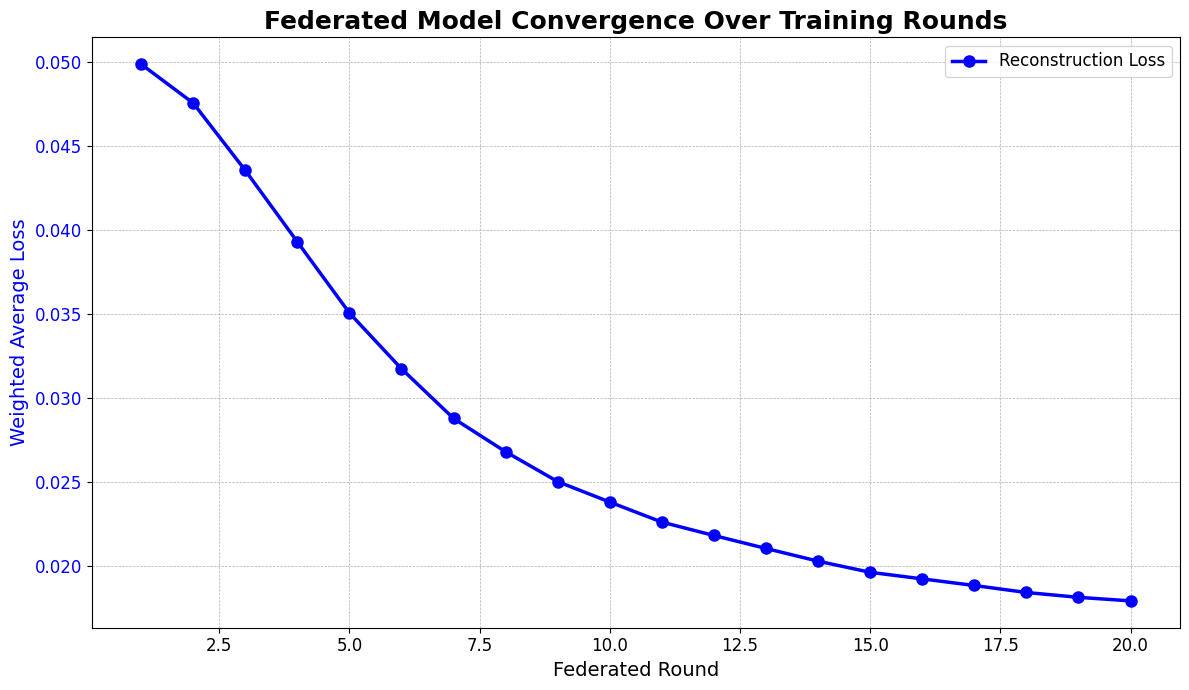

In [9]:
import matplotlib.pyplot as plt
import re

# --- 1. Extract Loss Values from the Training Log ---
# The 'history' variable contains the full text output from the training run
# We will use regular expressions to find the loss value from each round
loss_pattern = re.compile(r"Round weighted average loss \(FedProx\): ([\d.]+)")
loss_scores = []
for line in history:
    match = loss_pattern.search(line)
    if match:
        loss_scores.append(float(match.group(1)))

# --- 2. Generate the Plot ---
if loss_scores:
    rounds = list(range(1, len(loss_scores) + 1))

    fig, ax = plt.subplots(figsize=(12, 7))

    ax.plot(rounds, loss_scores, 'b-o', label='Reconstruction Loss', linewidth=2.5, markersize=8)
    ax.set_xlabel('Federated Round', fontsize=14)
    ax.set_ylabel('Weighted Average Loss', color='b', fontsize=14)
    ax.tick_params(axis='y', labelcolor='b', labelsize=12)
    ax.tick_params(axis='x', labelsize=12)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.title('Federated Model Convergence Over Training Rounds', fontsize=18, weight='bold')
    ax.legend(loc='upper right', fontsize=12)

    plt.tight_layout()
    plt.show()
else:
    print("Could not find loss values in the training history. Please ensure training completed successfully.")

## Evaluation

In [10]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import pickle
from collections import OrderedDict

# --- 1. Define Model Class and Helper Functions ---
class Autoencoder(nn.Module):
    def __init__(self, input_dim: int):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    def forward(self, x): return self.decoder(self.encoder(x))

def set_weights(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

# --- 2. Load the preprocessed data to get the test set ---
try:
    with open("fl-tabular/preprocessed_unsupervised.pkl", "rb") as f:
        processed_data = pickle.load(f)
    X_test_scaled = processed_data["X_test_scaled"]
    X_test_original = processed_data["X_test"]
    print("--- Successfully loaded preprocessed test data. ---")

    # NEW: Get the input dimension dynamically from the loaded data's shape
    INPUT_DIM = X_test_scaled.shape[1]
    print(f"--- Dynamically set INPUT_DIM to: {INPUT_DIM} ---")

    # --- 3. Load the final federated model weights ---
    with open("fl-tabular/final_model_fedprox.pkl", "rb") as f:
        final_weights = pickle.load(f)
    print("--- Successfully loaded final federated model weights. ---")

    # The model is now created with the dynamic dimension
    federated_model = Autoencoder(input_dim=INPUT_DIM)
    set_weights(federated_model, final_weights)
    federated_model.eval()

    # --- 4. Calculate reconstruction errors (anomaly scores) ---
    test_tensors = torch.from_numpy(X_test_scaled).float()
    with torch.no_grad():
        reconstructions = federated_model(test_tensors)
        errors = nn.MSELoss(reduction='none')(reconstructions, test_tensors).mean(axis=1).numpy()

    # --- 5. Identify top 5% anomalies ---
    threshold = np.percentile(errors, 95)
    fl_anomalies_df = X_test_original.iloc[np.where(errors > threshold)[0]]

    # --- 6. Print the results ---
    print("\n" + "="*60)
    print("--- Profile of Anomalies (Federated Autoencoder) ---")
    print(fl_anomalies_df[['claim']].describe())
    print("="*60)

except FileNotFoundError as e:
    print(f"Error: Could not find a required file. Please ensure both preprocessing and training have been run.\nDetails: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

--- Successfully loaded preprocessed test data. ---
--- Dynamically set INPUT_DIM to: 140 ---
--- Successfully loaded final federated model weights. ---

--- Profile of Anomalies (Federated Autoencoder) ---
              claim
count    150.000000
mean   22929.251333
std    13597.711321
min     1163.500000
25%    12060.975000
50%    21939.000000
75%    33254.750000
max    60021.400000


# Comparison
Table 3: Overlap Analysis Between the Optimized Federated Autoencoder and Centralized Benchmark Models. Values represent the percentage of anomalies flagged by the federated model that were also flagged by the respective centralized model.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import pickle
from collections import OrderedDict
from torch.utils.data import DataLoader, TensorDataset
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from IPython.display import display

# --- 1. Define Model Class and Helper Functions ---
class Autoencoder(nn.Module):
    def __init__(self, input_dim: int):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.4)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128), nn.BatchNorm1d(128), nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    def forward(self, x): return self.decoder(self.encoder(x))

def set_weights(net, parameters):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

# --- 2. Load the preprocessed .pkl file ---
try:
    with open("fl-tabular/preprocessed_unsupervised.pkl", "rb") as f:
        processed_data = pickle.load(f)

    X_train_scaled = processed_data["X_train_scaled"]
    X_test_scaled = processed_data["X_test_scaled"]
    X_test_original = processed_data["X_test"]
    input_dim = processed_data["input_dim"]

    print("--- Successfully loaded preprocessed data for all models. ---")
    print(f"--- Data dimension is correctly set to: {input_dim} ---")

except FileNotFoundError:
    print("Error: Could not find 'preprocessed_unsupervised.pkl'. Please run the main preprocessing cell first.")
    X_train_scaled = None

if X_train_scaled is not None:
    # --- 3. Train Centralized Models & Find Anomalies ---
    print("\n--- Training centralized models on new data... ---")

    # Model A: Centralized Autoencoder
    centralized_ae = Autoencoder(input_dim)
    train_tensors = torch.from_numpy(X_train_scaled).float()
    train_loader = DataLoader(TensorDataset(train_tensors), batch_size=32, shuffle=True)
    criterion = nn.MSELoss(); optimizer = optim.Adam(centralized_ae.parameters(), lr=0.001)
    centralized_ae.train()
    for epoch in range(20):
        for data_batch in train_loader:
            inputs = data_batch[0]; optimizer.zero_grad(); outputs = centralized_ae(inputs)
            loss = criterion(outputs, inputs); loss.backward(); optimizer.step()

    test_tensors = torch.from_numpy(X_test_scaled).float()
    centralized_ae.eval()
    with torch.no_grad():
        reconstructions = centralized_ae(test_tensors)
        errors = nn.MSELoss(reduction='none')(reconstructions, test_tensors).mean(axis=1).numpy()
    threshold = np.percentile(errors, 95)
    central_ae_indices = X_test_original.iloc[np.where(errors > threshold)[0]].index

    # Model B: Centralized Isolation Forest
    iso_forest = IsolationForest(contamination=0.05, random_state=42).fit(X_train_scaled)
    iso_preds = iso_forest.predict(X_test_scaled)
    central_iso_indices = X_test_original.iloc[np.where(iso_preds == -1)[0]].index

    # Model C: Centralized K-Means
    kmeans = KMeans(n_clusters=8, random_state=42, n_init='auto').fit(X_train_scaled)
    distances = kmeans.transform(X_test_scaled).min(axis=1)
    threshold = np.percentile(distances, 95)
    central_km_indices = X_test_original.iloc[np.where(distances > threshold)[0]].index

    # --- 4. Get FEDERATED Anomalies ---
    print("--- Loading and evaluating federated model... ---")
    with open("fl-tabular/final_model_fedprox.pkl", "rb") as f:
        final_weights = pickle.load(f)
    federated_model = Autoencoder(input_dim)
    set_weights(federated_model, final_weights)
    federated_model.eval()
    with torch.no_grad():
        reconstructions = federated_model(test_tensors)
        errors = nn.MSELoss(reduction='none')(reconstructions, test_tensors).mean(axis=1).numpy()
    threshold = np.percentile(errors, 95)
    fl_anomaly_indices = X_test_original.iloc[np.where(errors > threshold)[0]].index

    # --- 5. MODIFIED: Calculate Overlaps and Create Table 3 ---
    total_fl_anomalies = len(fl_anomaly_indices)

    if total_fl_anomalies > 0:
        # Calculate overlaps
        common_ae = np.intersect1d(central_ae_indices, fl_anomaly_indices)
        common_iso = np.intersect1d(central_iso_indices, fl_anomaly_indices)
        common_km = np.intersect1d(central_km_indices, fl_anomaly_indices)

        # Prepare data for the table
        table_data = [
            {
                "Centralized Model Benchmark": "K-Means",
                "Overlap with Federated Model": f"{len(common_km) / total_fl_anomalies:.2%} ({len(common_km)} claims)"
            },
            {
                "Centralized Model Benchmark": "Isolation Forest",
                "Overlap with Federated Model": f"{len(common_iso) / total_fl_anomalies:.2%} ({len(common_iso)} claims)"
            },
            {
                "Centralized Model Benchmark": "Autoencoder",
                "Overlap with Federated Model": f"{len(common_ae) / total_fl_anomalies:.2%} ({len(common_ae)} claims)"
            }
        ]

        overlap_table = pd.DataFrame(table_data)

        print("\nTable 3: Overlap Analysis Between the Optimized Federated Autoencoder and Centralized Benchmark Models")
        display(overlap_table)
    else:
        print("\nFederated model did not flag any anomalies. Overlap table cannot be generated.")

--- Successfully loaded preprocessed data for all models. ---
--- Data dimension is correctly set to: 140 ---

--- Training centralized models on new data... ---
--- Loading and evaluating federated model... ---

Table 3: Overlap Analysis Between the Optimized Federated Autoencoder and Centralized Benchmark Models


,Centralized Model Benchmark,Overlap with Federated Model
0,K-Means,47.33% (71 claims)
1,Isolation Forest,35.33% (53 claims)
2,Autoencoder,13.33% (20 claims)


# Extracting the Project

In [12]:
!zip -r project_archive.zip fl-tabular

  adding: fl-tabular/ (stored 0%)
  adding: fl-tabular/health.csv (deflated 79%)
  adding: fl-tabular/README.md (deflated 56%)
  adding: fl-tabular/preprocessed_unsupervised.pkl (deflated 95%)
  adding: fl-tabular/fltabular/ (stored 0%)
  adding: fl-tabular/fltabular/__pycache__/ (stored 0%)
  adding: fl-tabular/fltabular/__pycache__/task.cpython-312.pyc (deflated 46%)
  adding: fl-tabular/fltabular/__pycache__/__init__.cpython-312.pyc (deflated 19%)
  adding: fl-tabular/fltabular/__pycache__/client_app.cpython-312.pyc (deflated 45%)
  adding: fl-tabular/fltabular/__pycache__/server_app.cpython-312.pyc (deflated 40%)
  adding: fl-tabular/fltabular/server_app.py (deflated 61%)
  adding: fl-tabular/fltabular/client_app.py (deflated 61%)
  adding: fl-tabular/fltabular/task.py (deflated 64%)
  adding: fl-tabular/fltabular/__init__.py (deflated 3%)
  adding: fl-tabular/pyproject.toml (deflated 49%)
  adding: fl-tabular/final_model_fedprox.pkl (deflated 8%)
